Extract feature from TVDN. 


In [1]:
import sys
sys.path.append("../mypkg")

In [2]:
from constants import RES_ROOT, FIG_ROOT, DATA_ROOT
from utils.misc import load_pkl, save_pkl
from utils.colors import qual_cmap
from pyTVDN import TVDNDetect

In [3]:
%load_ext autoreload
%autoreload 2
# 0,1, 2, 3, be careful about the space

In [4]:
import numpy as np
import itertools
import scipy
from scipy.io import loadmat
from scipy import signal
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, trange
import bct # the pkg to get graph features
from joblib import Parallel, delayed
from easydict import EasyDict as edict
import pandas as pd
from IPython.display import display

plt.style.use(FIG_ROOT/'base.mplstyle')

# Fns and params

## Some fns

In [38]:
from prettytable import PrettyTable as PT
from scipy.stats import f_oneway, ttest_ind, mannwhitneyu 

def _get_test_tb(res_df):
    tb = PT()
    tb.field_names = ["Test", "Pval", "Effect size"]
    
    HC = res_df["metric"][res_df["diagnosis"]==6]
    
    def indicator(pval):
        if pval < 0.05:
            return "*"
        else:
            return ""
    # list all disease
    for diag_ix in range(1, 6):
        DS = res_df["metric"][res_df["diagnosis"]==diag_ix]
        ttest_res = ttest_ind(DS, HC)
        ttest_res1 = mannwhitneyu(DS, HC)
        effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
        tb.add_row([f"{indicator(ttest_res.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                      f"{ttest_res.pvalue:>6.3f}", 
                      f"{effect_size:>6.3f}"])
        tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}{diag_lab_mapping[diag_ix]} vs HC", 
                    f"{ttest_res1.pvalue:>6.3f}", 
                    f"{effect_size:>6.3f}"])
    
    # pool 5 diseases together
    DS = res_df["metric"][res_df["diagnosis"]!=6]
    ttest_res = ttest_ind(DS, HC)
    ttest_res1 = mannwhitneyu(DS, HC)
    effect_size = (np.mean(DS)-np.mean(HC))/np.std(np.concatenate([DS, HC]), ddof=2)
    tb.add_row([f"{indicator(ttest_res.pvalue)}Dementia vs HC", 
                f"{ttest_res.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    tb.add_row([f"(non-param) {indicator(ttest_res1.pvalue)}Dementia vs HC", 
                f"{ttest_res1.pvalue:>6.3f}", 
                f"{effect_size:>6.3f}"])
    
    # anova
    metric_grp = [res_df["metric"][res_df["diagnosis"]==grp_ix] for grp_ix in range(1, 7)]
    anova_res = f_oneway(*metric_grp)
    tb.add_row([f"{indicator(anova_res.pvalue)}ANOVA", 
                f"{anova_res.pvalue:>6.3f}", 
                f""])
    tb.align["Test"] = "r"
    tb.align["Pval"] = "c"
    tb.align["Effect size"] = "c"
    return tb

In [9]:
def _preprocess_ts(ts):
    """preprocessing, 
        1. detrend
        2. resample (len of seq has 235 or 555, I make it consistent to 235)
    """
    ts = signal.detrend(ts);
    if ts.shape[-1] > 235:
        ts = signal.resample(ts, num=235, axis=-1)
    return ts
    
    
def _load_data(n):
    """Sub idx is from 1, n: the sub idx
    """
    return mat_data['ts_321_273'][np.where(mat_data['subj_321_ts'][:, 0] == n)[0], :].transpose()

## Load data and params

In [10]:
# load data
mat_data = loadmat(DATA_ROOT/"ad_ftd_hc_fmri_data.mat");


yeo_7nets_dict = pd.read_csv(DATA_ROOT/"yeo_7nets_dict.txt");
yeo_7nets_dict = {yeo_7nets_dict["lab"][ix]:"_".join(yeo_7nets_dict["name"][ix].strip().split(" "))
                  for ix in range(7)}
yeo_7nets_ts = load_pkl(DATA_ROOT/"ad_ftd_hc_fmri_data_7nets.pkl");

num_rois = 246 # the BNA has 246 regions
num_sps = 321
ac_time = 485

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../data/ad_ftd_hc_fmri_data_7nets.pkl


485

In [11]:
diag_labs = mat_data["dx_321"].reshape(-1)
sex_labs = mat_data["sex_321"].reshape(-1)
mmse_scores = mat_data["mmse_321"].reshape(-1)
diag_lab_mapping = {
 1: "AD",
 2: "bvFTD",
 3: "CBS", 
 4: "nfvPPA", 
 5: "svPPA", 
 6: "HC"
}

{1: 'AD', 2: 'bvFTD', 3: 'CBS', 4: 'nfvPPA', 5: 'svPPA', 6: 'HC'}

# Run TVDN

In [55]:
tvdn_paras = edict()
# these two are most influential
tvdn_paras.fct = 0.1
tvdn_paras.lamb = 5e-5
# r is moderately influential
tvdn_paras.r = 0.8
# not very important
tvdn_paras.Lmin = 5
tvdn_paras.MaxM = 20

#tvdn_paras.kappas = np.linspace(1, 2, 100)
tvdn_paras.kappas = np.linspace(1, 2, 1000)

## Get results


In [11]:
def _run_fn(sub_ix, net_ix):
    ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]][sub_ix-1];
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_7nets_res_MaxM20_fixr8",
                     fName=f"sub_{sub_ix}_{yeo_7nets_dict[net_ix]}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return None


In [12]:
all_coms = itertools.product([1, 2, 3, 4, 5, 6, 7], range(1, num_sps+1))
with Parallel(n_jobs=15) as parallel:
    res = parallel(delayed(_run_fn)(sub_ix, net_ix) 
                   for net_ix, sub_ix 
                   in tqdm(all_coms, total=num_sps*7))

 35%|██████████████████████████████████████████████▊                                                                                        | 780/2247 [20:27<39:26,  1.61s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_3_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_17_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_30_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_46_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_61_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_76_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebo

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_11_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_28_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_43_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_57_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_72_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_85_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/noteb

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_8_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_22_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_35_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_51_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_68_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_81_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebo

 35%|███████████████████████████████████████████████▊                                                                                       | 795/2247 [20:51<39:21,  1.63s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_10_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_24_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_39_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_53_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_66_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_83_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/noteb

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_13_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_27_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_41_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_58_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_70_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_87_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/noteb

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_7_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_25_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_42_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_56_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_71_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_86_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebo

 36%|████████████████████████████████████████████████▋                                                                                      | 810/2247 [21:16<39:00,  1.63s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_15_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_38_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_54_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_69_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_82_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_97_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/noteb

 37%|█████████████████████████████████████████████████▌                                                                                     | 825/2247 [21:41<39:02,  1.65s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_14_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_40_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_55_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_73_Visual_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_90_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_105_Visual_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/note

 68%|███████████████████████████████████████████████████████████████████████████████████████████▏                                          | 1530/2247 [40:36<18:50,  1.58s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_123_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_138_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_155_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_169_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_183_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_198_Dorsal_Attention_Rank8.pkl.
Save Main 

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_121_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_137_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_152_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_170_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_185_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_200_Dorsal_Attention_Rank8.pkl.
Save Main 

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_119_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_134_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_149_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_164_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_179_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_193_Dorsal_Attention_Rank8.pkl.
Save Main 

 69%|████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 1545/2247 [41:01<18:41,  1.60s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_133_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_147_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_162_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_177_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_192_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_207_Dorsal_Attention_Rank8.pkl.
Save Main 

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_132_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_148_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_163_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_178_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_194_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_209_Dorsal_Attention_Rank8.pkl.
Save Main 

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_131_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_144_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_160_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_176_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_191_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_202_Dorsal_Attention_Rank8.pkl.
Save Main 

 69%|█████████████████████████████████████████████████████████████████████████████████████████████                                         | 1560/2247 [41:25<18:28,  1.61s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_143_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_158_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_174_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_189_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_204_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_217_Dorsal_Attention_Rank8.pkl.
Save Main 

 71%|██████████████████████████████████████████████████████████████████████████████████████████████▊                                       | 1590/2247 [42:12<17:12,  1.57s/it]

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_157_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_173_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_187_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_203_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_218_Dorsal_Attention_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_234_Dorsal_Attention_Rank8.pkl.
Save Main 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2247/2247 [59:37<00:00,  1.59s/it]


Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_240_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_254_Limbic_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_270_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_285_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_300_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_316_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_243_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_257_Limbic_Rank9.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_274_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_291_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_307_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_1_Frontoparietal_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jess

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_231_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_247_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_259_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_273_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_289_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_305_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_230_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_248_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_264_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_280_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_297_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_309_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_249_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_265_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_281_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_295_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_312_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_6_Frontoparietal_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jess

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_237_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_251_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_267_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_282_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_296_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_310_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_250_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_263_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_276_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_287_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_303_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_317_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data

Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_233_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_246_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_261_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_277_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_290_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdn_7nets_res_MaxM20_fixr8/sub_304_Limbic_Rank8.pkl.
Save Main Results at /data/rajlab1/user_data/jin/MyResearch/jesse_data

## Kappa find

In [57]:
def _run_fn(sub_ix, net_ix):
    ts = yeo_7nets_ts[yeo_7nets_dict[net_ix]][sub_ix-1];
    det = TVDNDetect(Ymat=ts,
                     showProgress=False,
                     saveDir=RES_ROOT/"tvdn_7nets_res_MaxM20",
                     fName=f"sub_{sub_ix}_{yeo_7nets_dict[net_ix]}",
                     dataType="fMRI", 
                     MaxM=tvdn_paras.MaxM, 
                     Lmin=tvdn_paras.Lmin, 
                     fct=tvdn_paras.fct, 
                     lamb=tvdn_paras.lamb, 
                     r=tvdn_paras.r); 
    #det.Screening(wh=5)
    det()
    det.TuningKappa(tvdn_paras.kappas)
    det.UpdateEcpts()
    return det


In [67]:
numchgss = []
for sub_ix in tqdm(np.where(diag_labs==6)[0]+1):
    det = _run_fn(sub_ix, net_ix=7)
    numchgss.append(det.numchgs)
numchgss = np.array(numchgss);

  0%|                                                                                                                                                  | 0/100 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:09<00:00, 10.67it/s]


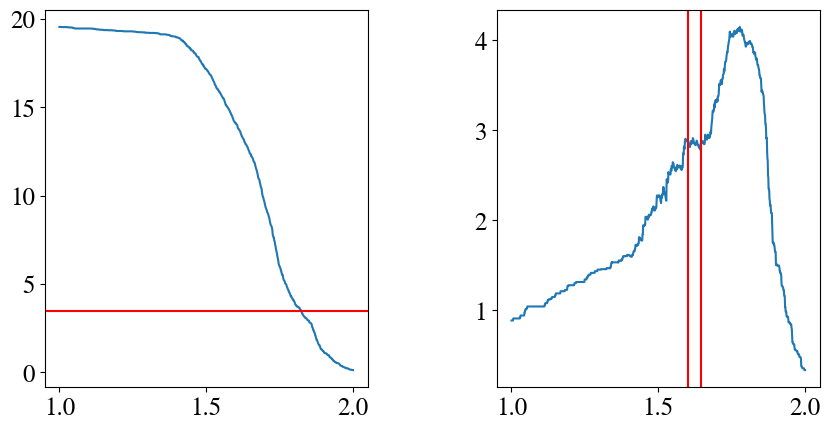

In [68]:
plt.subplot(121)
plt.plot(tvdn_paras.kappas, numchgss.mean(axis=0))
plt.axhline(y=3.5, color="red")
plt.subplot(122)
plt.plot(tvdn_paras.kappas, numchgss.std(axis=0))
#plt.xlim([1.40, 1.7])
plt.axvline(x=1.6, color="red")
plt.axvline(x=1.647, color="red")
# max of DMN is 1.67

In [71]:
kpidxs = np.where(np.bitwise_and(tvdn_paras.kappas>=1.6, tvdn_paras.kappas<=1.7))[0]
optkp_idx = kpidxs[np.argmin(numchgss.std(axis=0)[kpidxs])]
optkp = tvdn_paras.kappas[optkp_idx]
optkp = tvdn_paras.kappas[np.argmin(np.abs(numchgss.mean(axis=0)-12.5))]
print(f"The optimal kp is {optkp:.3f}.")

The optimal kp is 1.647.


## Get features

In [43]:
net_ix = 7

7

In [33]:
rks = []
for sub_ix in trange(1, num_sps+1):
    det = _run_fn(sub_ix, net_ix)
    rks.append(det.midRes.r)
save_pkl(RES_ROOT/f"tvdnMaxM20_fixr8_ranks_{yeo_7nets_dict[net_ix]}.pkl", rks)

  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:41<00:00,  7.76it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_fixr8_ranks_Default.pkl


In [46]:
#optkp = tvdn_paras.kappas[np.argmin(np.abs(tvdn_paras.kappas-1.647))]
def _run_fn1(sub_ix):
    det = _run_fn(sub_ix, net_ix)
    det.UpdateEcpts(det.numchgs[tvdn_paras.kappas==optkp][0])
    return det.ecpts

# n_jobs>1 makes it slow
with Parallel(n_jobs=1) as parallel:
    ecptss = parallel(delayed(_run_fn1)(sub_ix) for sub_ix in tqdm(range(1, num_sps+1), total=num_sps))
save_pkl(RES_ROOT/f"tvdnMaxM20_fixr8_ecptss_kp{optkp*1000:.0f}_{yeo_7nets_dict[net_ix]}.pkl", ecptss)

  0%|                                                                                                                                                  | 0/321 [00:00<?, ?it/s]/data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/pyTVDN/TVDNclass.py:348: UserWarning: As loading the saved results, kappa will be ignored
  warnings.warn("As loading the saved results, kappa will be ignored", UserWarning)
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:30<00:00, 10.53it/s]

Save to /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_fixr8_ecptss_kp1654_Default.pkl


# Analyze

In [46]:
net_ix = 7

7

In [47]:
_get_dwell = lambda ecpts: np.diff(np.concatenate([[0], ecpts, [235]]))*ac_time/235
rks = np.array(load_pkl(RES_ROOT/f"tvdnMaxM20_ranks_{yeo_7nets_dict[net_ix]}.pkl"));
ecptss = load_pkl(RES_ROOT/f"tvdnMaxM20_ecptss_kp1647_{yeo_7nets_dict[net_ix]}.pkl")
ncpts = np.array([len(ecpts) for ecpts in ecptss]);
dwells = [_get_dwell(ecpts) for ecpts in ecptss]; 
maxdwells = np.array([np.max(dwell) for dwell in dwells]);
meandwells = np.array([np.mean(dwell) for dwell in dwells]);

Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ranks_Default.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/jesse_data/notebooks/../mypkg/../results/tvdnMaxM20_ecptss_kp1647_Default.pkl


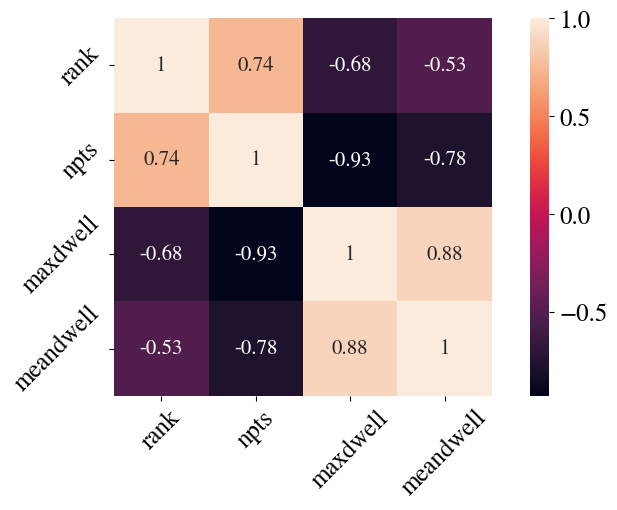

In [56]:
all_fs = np.stack([rks, ncpts, maxdwells, meandwells], axis=1)
corr_mat = np.corrcoef(all_fs.T);
sns.heatmap(corr_mat, annot=True, square=True)
fs_names = ["rank", "npts", "maxdwell", "meandwell"]
plt.xticks(np.arange(len(fs_names))+0.5, fs_names, rotation=45)
plt.yticks(np.arange(len(fs_names))+0.5, fs_names, rotation=45);

In [48]:
res_df = pd.DataFrame({
    "metric": rks, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
*AD vs HC,0.036,-0.311
(non-param) AD vs HC,0.058,-0.311
bvFTD vs HC,0.491,-0.128
(non-param) bvFTD vs HC,0.532,-0.128
CBS vs HC,0.878,-0.033
(non-param) CBS vs HC,0.869,-0.033
nfvPPA vs HC,0.709,0.074
(non-param) nfvPPA vs HC,0.609,0.074
svPPA vs HC,0.187,0.254
(non-param) svPPA vs HC,0.184,0.254


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,7.975610,1.227017,5.0,8.0,8.0,8.0,10.0
CBS,27.0,8.296296,0.912090,6.0,8.0,8.0,8.0,10.0
HC,100.0,8.330000,1.035287,6.0,8.0,8.0,8.0,10.0
bvFTD,41.0,8.195122,1.100443,6.0,8.0,8.0,8.0,10.0
nfvPPA,34.0,8.411765,1.281988,6.0,8.0,8.0,10.0,10.0
svPPA,37.0,8.594595,1.039750,6.0,8.0,8.0,10.0,10.0


In [43]:
res_df = pd.DataFrame({
    "metric": ncpts, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df))
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
*AD vs HC,0.010,-0.382
(non-param) AD vs HC,0.055,-0.382
bvFTD vs HC,0.389,-0.160
(non-param) bvFTD vs HC,0.423,-0.160
CBS vs HC,0.876,0.034
(non-param) CBS vs HC,0.484,0.034
nfvPPA vs HC,0.961,-0.010
(non-param) nfvPPA vs HC,0.318,-0.010
svPPA vs HC,0.352,0.179
(non-param) svPPA vs HC,0.275,0.179


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,11.060976,4.514305,0.0,11.0,13.0,14.0,16.0
CBS,27.0,12.592593,2.042985,4.0,12.0,13.0,14.0,14.0
HC,100.0,12.500000,2.872721,2.0,12.0,13.0,14.0,15.0
bvFTD,41.0,12.024390,3.181885,2.0,12.0,13.0,14.0,15.0
nfvPPA,34.0,12.470588,3.404412,3.0,13.0,14.0,14.0,16.0
svPPA,37.0,13.000000,2.527625,0.0,13.0,14.0,14.0,15.0


In [61]:
res_df = pd.DataFrame({
    "metric": maxdwells, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df)) 
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
*AD vs HC,0.005,0.419
(non-param) AD vs HC,0.057,0.419
bvFTD vs HC,0.293,0.195
(non-param) bvFTD vs HC,0.214,0.195
CBS vs HC,0.515,-0.141
(non-param) CBS vs HC,0.748,-0.141
nfvPPA vs HC,0.971,-0.007
(non-param) nfvPPA vs HC,0.876,-0.007
svPPA vs HC,0.764,-0.058
(non-param) svPPA vs HC,0.362,-0.058


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,109.433316,118.882654,35.085106,45.404255,56.755319,84.101064,485.000000
CBS,27.0,62.526399,36.704471,39.212766,46.436170,51.595745,62.946809,231.148936
HC,100.0,70.397234,59.618707,35.085106,43.340426,51.595745,64.494681,346.723404
bvFTD,41.0,82.855215,72.465941,37.148936,45.404255,55.723404,74.297872,359.106383
nfvPPA,34.0,69.988110,50.801289,39.212766,43.340426,50.563830,68.622340,243.531915
svPPA,37.0,66.711903,74.004366,37.148936,43.340426,47.468085,61.914894,485.000000


In [45]:
res_df = pd.DataFrame({
    "metric": meandwells, 
    "sex": sex_labs, 
    "diagnosis": diag_labs
})
res_df["diagnosis1"] = res_df["diagnosis"].map(diag_lab_mapping)
display(_get_test_tb(res_df)) 
res_df.groupby("diagnosis1")["metric"].describe()

Test,Pval,Effect size
*AD vs HC,0.006,0.405
(non-param) *AD vs HC,0.042,0.405
bvFTD vs HC,0.719,0.067
(non-param) bvFTD vs HC,0.531,0.067
CBS vs HC,0.479,-0.154
(non-param) CBS vs HC,0.556,-0.154
nfvPPA vs HC,0.881,0.030
(non-param) nfvPPA vs HC,0.407,0.030
svPPA vs HC,0.541,0.118
(non-param) svPPA vs HC,0.217,0.118


,count,mean,std,min,25%,50%,75%,max
diagnosis1,,,,,,,,
AD,82.0,68.299635,93.961519,28.529412,32.333333,34.642857,40.416667,485.000000
CBS,27.0,37.368107,12.298639,32.333333,32.333333,34.642857,37.307692,97.000000
HC,100.0,41.017567,25.865650,30.312500,32.333333,34.642857,37.307692,161.666667
bvFTD,41.0,42.730228,24.947042,30.312500,32.333333,34.642857,37.307692,161.666667
nfvPPA,34.0,41.775671,24.339298,28.529412,32.333333,32.333333,34.642857,121.250000
svPPA,37.0,46.240565,74.206401,30.312500,32.333333,32.333333,34.642857,485.000000
